# Demographics

Dunnhumby: The Complete Journey

Nathaniel Poland


*In this notebook we'll take a look at the `hh_demographic.csv` table; demographic information for 801 of the 2500 household answers collected by user survey*



## Customer Focus

The project as a whole is based around understanding the purchase behaviour of customers of the grocery chain. We would be happy to have some sort of **customer profile**, which offers context to any findings regarding the purchase behaviour of any given `household_key`.


### Bias of our sample data; is it representative of the underlying population?

We recognize the dangers of an **inherent sampling bias** in our data; the 2500 households for which we have transactions are already a subsection of our total population. We have to assume that we only have demographic information from those who opted to take the survey; but we still can't be sure what the selection process was.

Moreover, this demographic **data was generated and entered by human input**.


### Demographics or Transactions?

I'd like to segment customers (households) into groups; this allows for targeted advertising through the recommender system we will bring online later.

To this end, does it make sense to have a customer profile based on how households **interacted with our stores through transactions**? Or, through **demographic labels**?

As far as supervised and unsupervised learning goes, we are searching for **viable target features** which clearly distinguish our customer segments from one another will be useful. 

## Business Summary/tl;dr

INPUTS/OBSERVATIONS:
- 32% of 2500 total households are represented by the 801 `household_key`s in this data.
    - **These households represent 56% of total revenue in the `transaction_data.csv` file, a significant percentage.**  

- Sample Bias & Confusing Questions
    - Unknown values in marital status, homeowner status, kid description
    
- **Households vary in size (number of members), potentially distorting our analysis**
    - Despite potentially representing distinct members of a household, we have a singular value for both the age and income columns
    
- Many columns have poorly distributed classes; we can use pd.Categorical columns, or clean up the distributions by forcing binary labels (which is arbitrary, and might lead to biased, misleading, or uninformative results).

# EDA for `hh_demographic.csv`

## Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']==(16,6)
import dtcj

plt.rcParams['figure.figsize']=(16,6)
plt.style.use('seaborn')

import seaborn as sns

## Importing Data

In [3]:
demo = pd.read_csv('data/hh_demographic.csv')

In [4]:
print(demo.info())
demo.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB
None


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [5]:
demo.household_key.duplicated().sum()

0

- The table consists of 801 rows of demographic information, each for a unique `household_key`. 

- There are no null values

- The data is largely in 'object' format; strings; the exception is the unique identifier, `household_key`.

In [6]:
### There are 8 columns in the table. Below are the skeleton value counts:

# for col in demo.drop('household_key', axis=1):
#     print(demo[col].value_counts())

Further below we will plot this information in a more readable way.

# Data Dictionary for `hh_demographic.csv`
`AGE_DESC`
Good descriptive information, but poorly balanced classes.

`MARITAL_STATUS_CODE` per the data dictionary available online:

    A = married
    B = single
    U = unknown

`INCOME_DESC` Many distinct values, including with income ranges 100K+; perhaps due to double income.

`HOMEOWNER_DESC`
Around 1/4 unknown values; homeowner or renter.

`HH_COMP_DESC`
Household composition description; string labels for household type including gender for individuals. This column allows us to distinguish single parents with kids from couples.

`HOUSEHOLD_SIZE_DESC`
Ranging from 1-5+.

`KID_CATEGORY_DESC`
Almost three quarters None/unknown values.

`household_key`
Unique Identifier for each household

In [7]:
demo.household_key.duplicated().sum()
# no duplicate household_keys

0

## Applying Categorical Ranks

Without losing any information at all, we can change the columns to pd.Categorical data type. This constructor allows us to 'rank' the category labels; this makes visualization more simple. By passing the `ordered=False` argument, we can prevent misinterpretations of our ranks as being sequentially ordered; for income, age, or household size we keep the order.

In [33]:

def demo_map_categorical(demo):
    demo['AGE_DESC'] = pd.Categorical(demo['AGE_DESC'], ['19-24', '25-34','35-44',  '45-54', '55-64',  '65+',])

    demo['MARITAL_STATUS_CODE'] = pd.Categorical(demo['MARITAL_STATUS_CODE'].map({'A':'Married', 'B':'Single', 'U': 'Unknown'}), ['Married', 'Single', 'Unknown'], ordered=False)

    demo['INCOME_DESC']= pd.Categorical(demo['INCOME_DESC'], ['Under 15K','15-24K','25-34K', '35-49K', '50-74K','75-99K',  
           '100-124K', '125-149K', '150-174K', '175-199K', '200-249K','250K+', ])

    demo['HOMEOWNER_DESC']= pd.Categorical(demo['HOMEOWNER_DESC'], ['Homeowner', 'Unknown', 'Renter', 'Probable Renter', 'Probable Owner'], ordered=False)

    demo['HH_COMP_DESC']=pd.Categorical(demo['HH_COMP_DESC'], ['Single Female', 'Single Male', '1 Adult Kids','2 Adults No Kids', '2 Adults Kids', 'Unknown',], ordered=False)
    demo['HOUSEHOLD_SIZE_DESC'] = pd.Categorical(demo['HOUSEHOLD_SIZE_DESC'], ['1', '2','3','4','5+',])
    demo['KID_CATEGORY_DESC']=pd.Categorical(demo['KID_CATEGORY_DESC'], ['1','2','3+','None/Unknown', ])
    
    return demo

demo_map_categorical(demo)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,NaN,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,NaN,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,NaN,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,NaN,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,NaN,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,NaN,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,NaN,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,NaN,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,NaN,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


## Plotting Class Distributions for Demographics

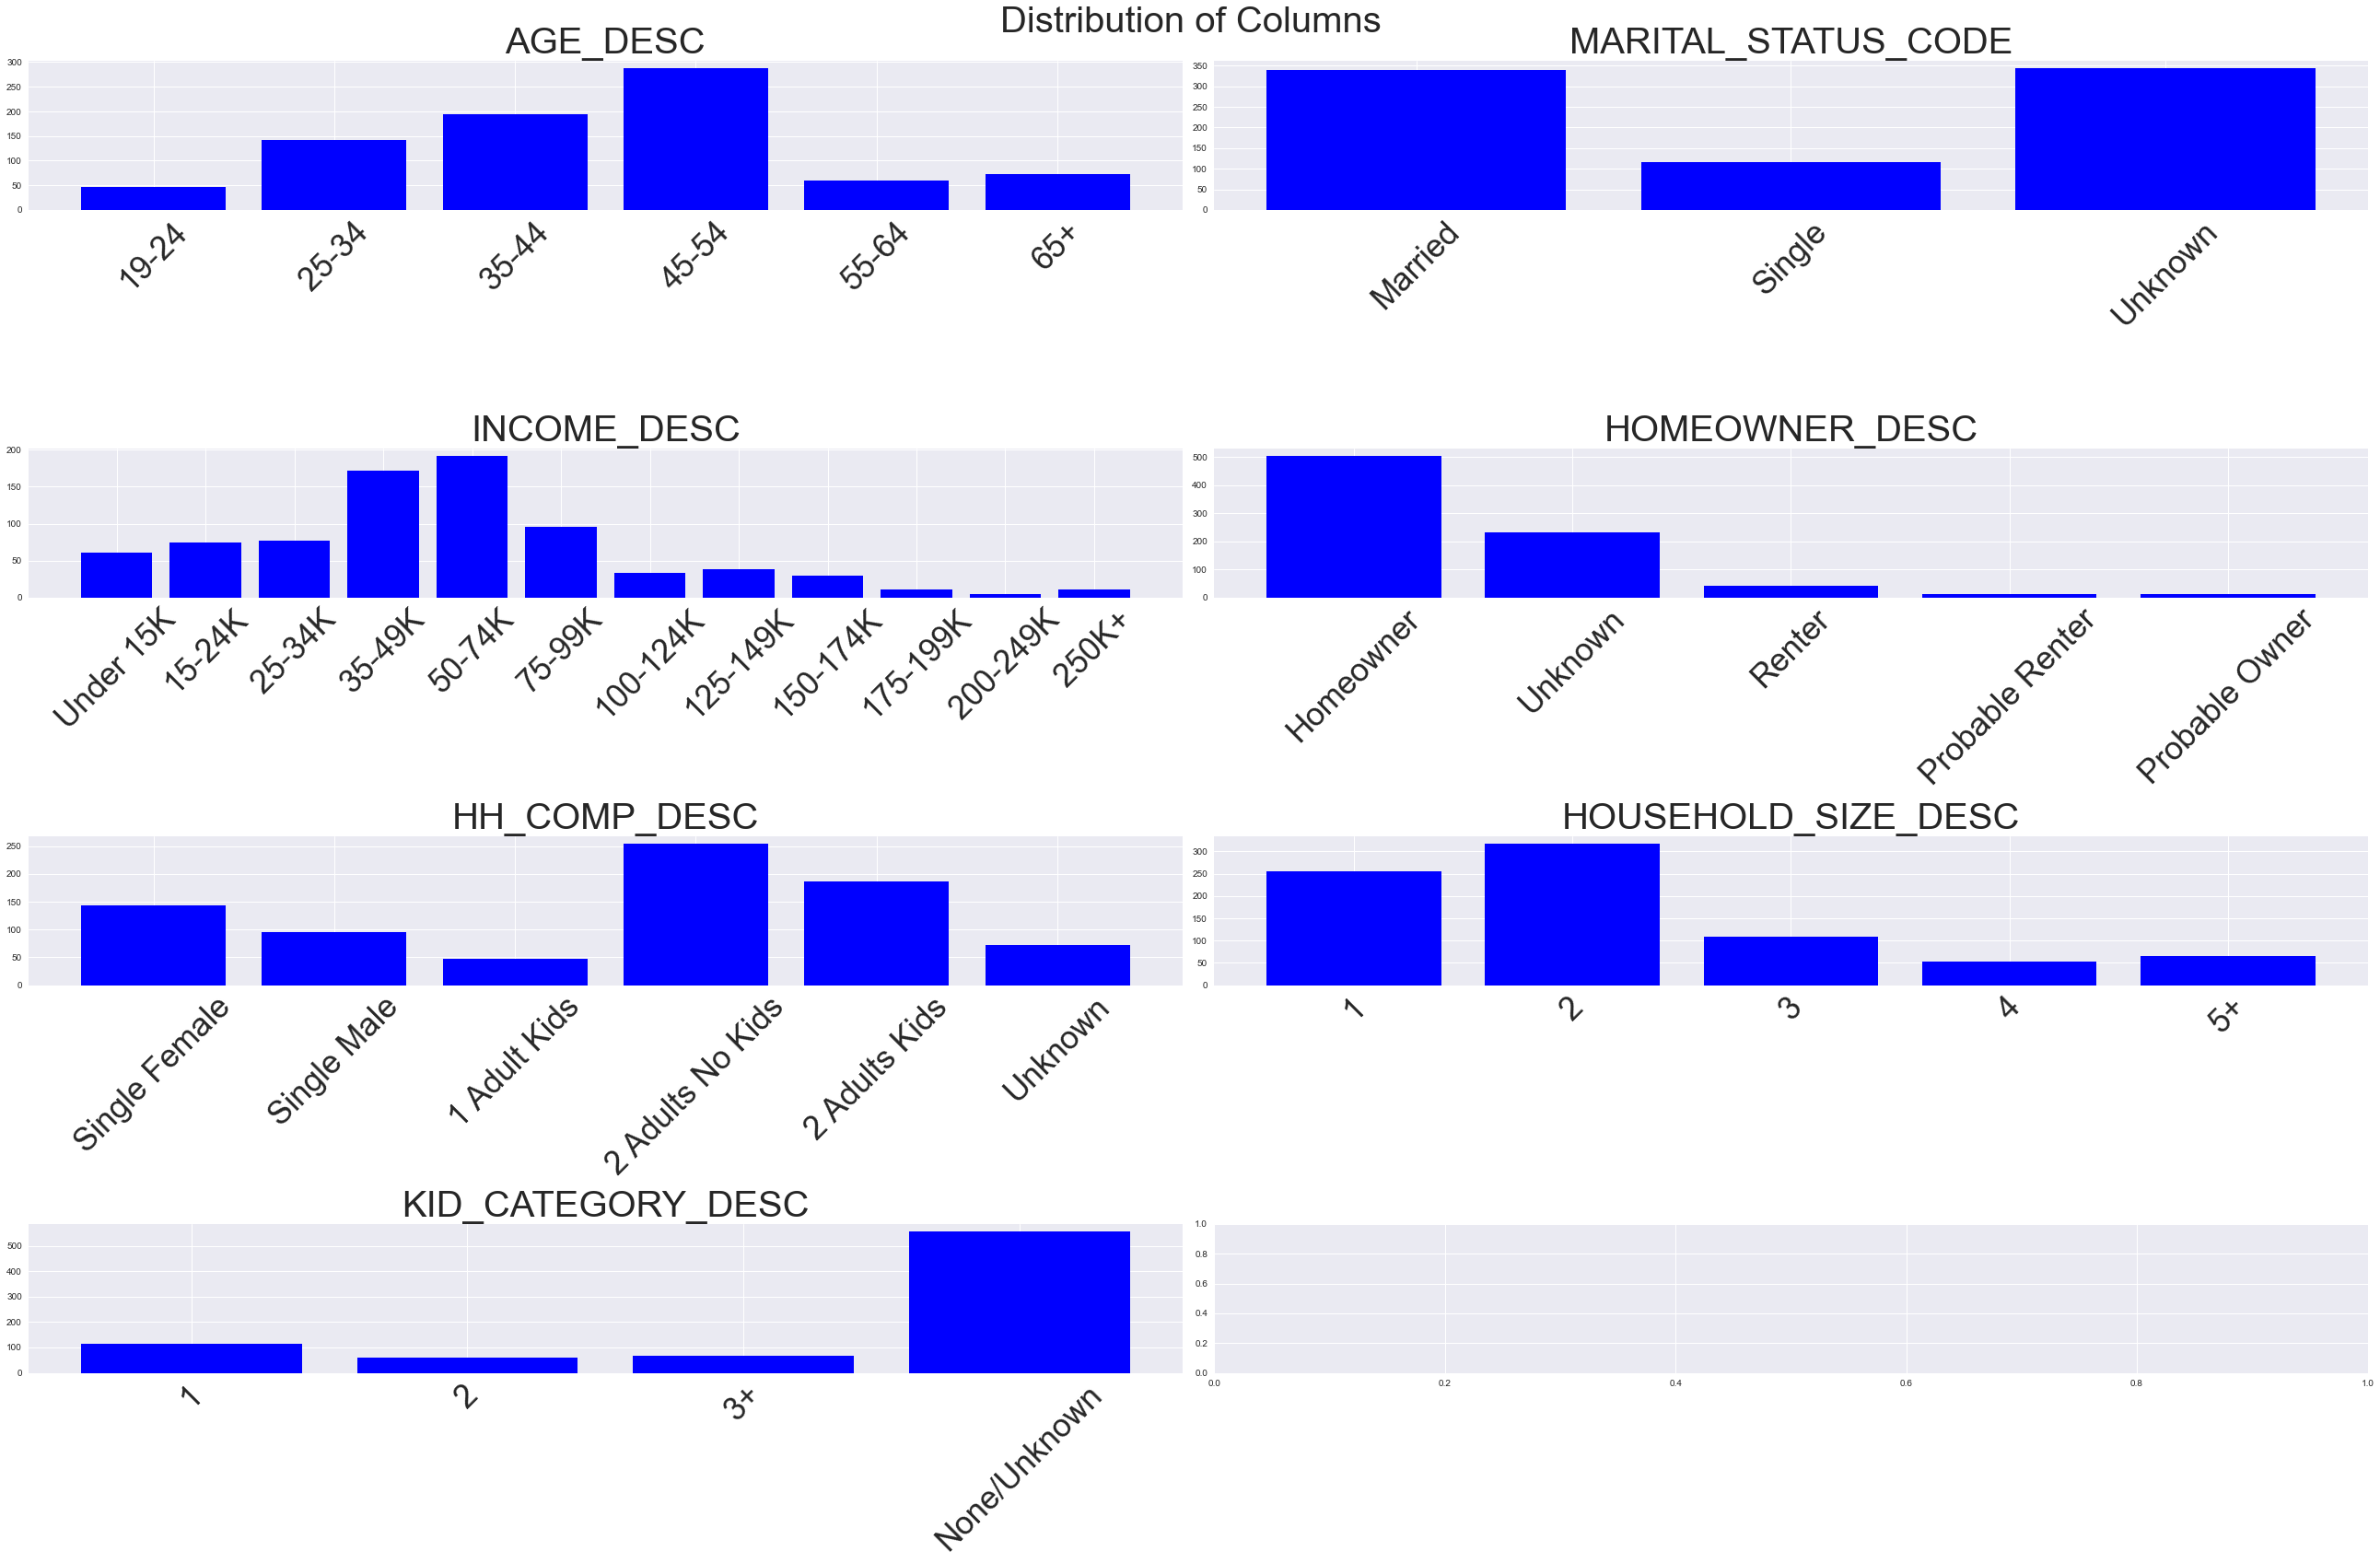

In [9]:
def plot_demo_distributions():
    columns = 2
    rows = (len(demo.columns)-1)//columns + 1
    plt.subplots(rows, columns, figsize=(36, 24))
    plt.suptitle('Distribution of Columns', size=40)
    for idx, col in enumerate(demo.drop('household_key', axis=1).columns):
        data = dict(demo[col].value_counts())
        order = list(demo[col].cat.categories)
        plt.subplot(rows, columns, idx+1)
        plt.title(f'{col}', size=40)
        plt.xticks(fontsize=35, rotation=45)
        for x in order:
            plt.bar(x, data[x], color='blue')

    plt.tight_layout()
    plt.show()
plot_demo_distributions()

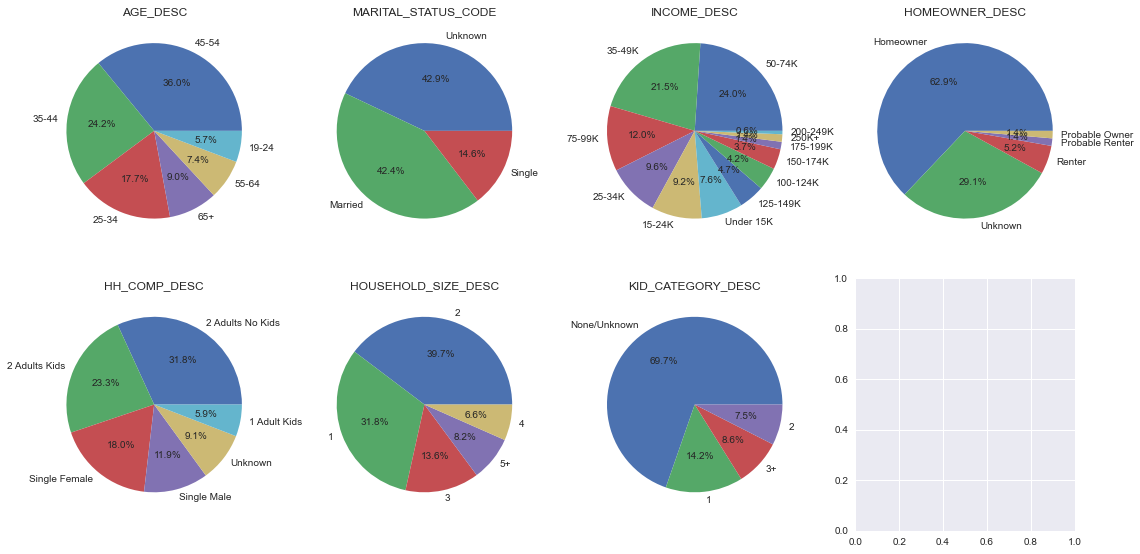

In [10]:
dtcj.plot_pies(demo.drop('household_key', axis=1))

### Observations of Distributions

**`AGE_DESC`**

- The households in our survey are leaning significantly towards the elderly age groups. **More than half the households for which we have demographic info report an age of 45+** 

**`HOMEOWNER_DESC`** 

- According to this data, **more than 63% of the households for which we have demographic info likely own homes**.

**`HOUSEHOLD_SIZE_DESC`** 
- Seems to be the most complete and informative column about our household sizes here -- what I might guess is the most relevant factor with respect to comparisons with an RFM score. 
- **No NaN or Unknown values**

**`HH_COMP_DESC`** 

- Creates some definition and variance in the data -- guided by someone with more experience, I might consider delving in here. 
    - **'Unknown' values makes up 9% of the column**.
    - We could drop the 9% of rows, or impute their values somehow, based on a swag-y guess using the household size desc. 
    - Taking it one step further, we could examine sales patterns for the households, to add a second decision boundary.
- It seemingly separates Single male and female individuals -- as well as single-parent households with kids, which might be a point of confusion. 


**`KID_CATEGORY_DESC`** 

- Combined, **None and Unknown labels make up more than 2/3 of the column**
- 31.3% of the households 'have kids' confirmed; compared with 28.4% of households in the 'HH_COMP_DESC' of size 3 or greater. 

Using the recommender system class shown later in the project, we could examine households in these various categories and promote advertising based on their most recent purchases.

# `hh_demographic` Sales Totals

In [11]:
# import the full transactions table for a basic reference 
transactions = pd.read_csv('data/transaction_data.csv')

In [12]:
# transactions = dtcj.load_merged()

In [13]:
# list of household_keys in hh_demographic
demo_hh = demo['household_key'].values

demo_sales = transactions[transactions['household_key'].isin(demo_hh)]['SALES_VALUE'].sum()

non_demo_sales = transactions[~transactions['household_key'].isin(demo_hh)]['SALES_VALUE'].sum()

total_sales = demo_sales + non_demo_sales

print(f'{round(total_sales, 2)} is the total sales value across all households.')
print()

print(f'{round(demo_sales, 2)} is the total sales value of households with demographic information listed.')
print()
print(f'{round(non_demo_sales, 2)} is the total sales value of households NOT listed in hh_demographic.')
print()

print(f'{round((demo_sales/total_sales) * 100,2)}% is the percentage of sales accounted for\nby households for which we have demographic information.')
print()
print(f'{round((non_demo_sales/total_sales) * 100,2)}% is the percentage of sales accounted for\nby households for which we do not have demographic information.')

8057463.08 is the total sales value across all households.

4497716.26 is the total sales value of households with demographic information listed.

3559746.82 is the total sales value of households NOT listed in hh_demographic.

55.82% is the percentage of sales accounted for
by households for which we have demographic information.

44.18% is the percentage of sales accounted for
by households for which we do not have demographic information.


**Despite making up only 32% of our households, the customers for which we have demographic information account for ~56% of the total sales in the data** (This is consistent even after the data cleaning which happens in the following notebooks).

We knew that the customers in our data were all purportedly **frequent shoppers** at our grocery chain, making market segmentation more difficult in some senses. However, this subset of customers is valuable; within the context of our data, and likely outside it. 

**We should be cautious about extrapolating any analysis or interpretations onto customers of the grocery chain as a whole**.

### Notes about Household Size

Households have a varying number of members. This will almost certainly impact the sales total for each household, as well as the products they might want to receive advertisements for.

We might imagine that **households with more members will require more food and other goods**, and therefore that families (or otherwise larger households) have the potential to be our highest-grossing "customers" as is defined in the data. 

**We should be careful about assuming this equates to higher overall revenue** as there might be less families around than individuals. Still, since the adults are the ones making purchases for a family, **advertising dollars spent on the parent of a family is likely to have a more significant sales impact** than on an individual; that one parent would be purchasing goods for several other people. Individuals or couples could be at an inherent 'disadvantage' in terms of total monetary value or frequency of purchases, but we'll have to take a closer look. We look at sales analysis by demographic category in following notebooks.

In terms of total sales by all individuals versus all families, we should again take note of our sampling bias. **We have a select few households in our demographic information** (and a select 2500 in our transactions info!).

**These class distributions and spending totals are not necessarily representative of the underlying population's demographic proportions or purchase behaviour.**

# Column Mappings

None of the transformations below are executed by the cells; they print the 'value counts'.

In [26]:
# AGE_DESC
demo['AGE_DESC'].map(
{
'19-24':"0-34",
'25-34':"0-34",
"35-44":"35-44",
'45-54':"45+",
'55-64':"45+",
'65+':"45+",
}).value_counts()
# Splitting 45+ results in a much smaller fourth class, adding another class imbalance.
# At least the other two categories are similar in size? 
# Are the two smaller classes the most 'variant'? in terms of their within-label spending, for our purposes??

45+      419
35-44    194
0-34     188
Name: AGE_DESC, dtype: int64

In [27]:
# MARITAL_STATUS_CODE
demo['MARITAL_STATUS_CODE'].value_counts()

# .map({'Married':1,
#       'Single':2,
#      'Unknown':0}).value_counts()

Unknown    344
Married    340
Single     117
Name: MARITAL_STATUS_CODE, dtype: int64

In [28]:
# INCOME_DESC
demo['INCOME_DESC'].map({'Under 15K': '0-49K',
 '175-199K': '100K+',
 '35-49K': '0-49K',
 '125-149K': '100K+',
 '150-174K': '100K+',
 '15-24K': '0-49K',
 '50-74K': '50-99K',
 '250K+': '100K+',
 '200-249K': '100K+',
 '100-124K': '100K+',
 '75-99K': '50-99K',
 '25-34K': '0-49K'}).value_counts()

# demo['INCOME_DESC'].map({
#                             'Under 15K': 0,
#                              '15-24K': 0,
#                              '25-34K': 0,
#                              '35-49K': 0,
#                              '50-74K': 1,
#                              '75-99K': 1,
#                              '100-124K': 1,
#                              '125-149K': 1,
#                              '150-174K': 1,                   
#                              '175-199K': 1,  
#                              '200-249K': 1,
#                              '250K+': 1,
#                             }).sum()

0-49K     384
50-99K    288
100K+     129
Name: INCOME_DESC, dtype: int64

In [29]:
# HOMEOWNER_DESC
demo['HOMEOWNER_DESC'].map({
"Homeowner":1,    
"Unknown":0,     
"Renter":0,     
"Probable Renter":0,     
"Probable Owner":1,        
}).value_counts()

# Homeowner vs. Unknown/Renter

1    515
0    286
Name: HOMEOWNER_DESC, dtype: int64

In [30]:
# HH_COMP_DESC -- consider dropping Unknown values?
demo['HH_COMP_DESC'].value_counts()

2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
Unknown              73
1 Adult Kids         47
Name: HH_COMP_DESC, dtype: int64

In [31]:
# HOUSEHOLD_SIZE_DESC series to type int; note we are changing 5+ to 5... (losing information here)
demo['HOUSEHOLD_SIZE_DESC'].map({'1':1, '2':2, '3':3, '4':4, '5+':5}).astype(int).value_counts()

2    318
1    255
3    109
5     66
4     53
Name: HOUSEHOLD_SIZE_DESC, dtype: int64

In [32]:
# KID_CATEGORY_DESC
# demo.drop('KID_CATEGORY_DESC', axis=1)

# Binary Mappings

## `single_couple_family`

In [22]:
demo['single_couple_family'] = demo['HOUSEHOLD_SIZE_DESC'].map({'1':1, '2':2, '3':3,'4':3,'5+':3})
demo['single_couple_family'] = pd.Categorical(demo['single_couple_family'], 
                                         [1,2,3,])

## `single`

In [23]:
demo['single'] =  np.where((demo['HH_COMP_DESC'] == 'Single Female') |
                               (demo['HH_COMP_DESC'] == 'Single Male') |
                               (demo['HOUSEHOLD_SIZE_DESC'] == '1'),
                                1, 0)

## `couple`

In [24]:
demo['couple'] =  np.where((demo['HH_COMP_DESC'] == '2 Adults no Kids'),
                                1, 0)

## `has_kids`

*Engineering a map for households with confirmed children*

In [25]:
# has_kids
demo['has_kids'] = np.where((demo['HH_COMP_DESC'] == '1 Adult Kids') |
                           (demo['HH_COMP_DESC'] == '2 Adults Kids') |
                            (demo['HOUSEHOLD_SIZE_DESC'].isin(['3', '4', '5+'])),
                            1, 0)

demo['has_kids'].value_counts()

0    559
1    242
Name: has_kids, dtype: int64

Using the queries below we can confirm that:

all entries labeled '1 Adult Kids' are now tagged appropriately as 'has_kids'

In [26]:
# demo[demo['HH_COMP_DESC']=='1 Adult Kids']

all entries labeled as '2 Adults No Kids' are appropriately NOT tagged as 'has_kids;'

In [27]:
# demo[demo['HH_COMP_DESC'] == '2 Adults No Kids']['has_kids'].sum()

## `age_45+`

I might be setting this boundary arbitrarily based on the class distributions of my test set.

In [28]:
# 
demo['AGE_DESC'].map(
{
'19-24':0,
'25-34':0,
"35-44":0,
'45-54':1,
'55-64':1,
'65+':1,
}).value_counts()


1    419
0    382
Name: AGE_DESC, dtype: int64